In [1]:
!pip install --upgrade pip
!pip install imutils
!pip install opencv-python
!pip install --upgrade scikit-learn==0.23.0

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


In [61]:
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
#базовые классификаторы, из которых собираем ансамбль
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
#классификатор для обучения ансамбля
from sklearn.linear_model import LogisticRegression
#чтобы собрать ансамбль
from sklearn.ensemble import StackingClassifier
#для печати картинок через plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imutils import paths
import numpy as np
import cv2
import os

In [3]:
def extract_histogram(image, bins = (8,8,8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [18]:
imagePaths = sorted(list(paths.list_images(r'C:\Users\Victor\Downloads\train')))
trainData = []
labels = []

for (i, imagePath) in enumerate(imagePaths):
    image = cv2.imread(imagePath, 1)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    hist = extract_histogram(image)
    trainData.append(hist)
    labels.append(label)

In [13]:
Y = [1 if x == 'cat' else 0 for x in labels]
print(labels[3])
print(Y[3])
#Image(filename=imagePaths[3])

cat
1


In [59]:
#train SVM
svm = LinearSVC(random_state = 414, C = 1.64)
svm.fit(trainData, Y)

LinearSVC(C=1.64, random_state=414)

In [77]:
#train tree
tree = DecisionTreeClassifier(criterion = 'entropy', 
                              min_samples_split = 10,
                              max_leaf_nodes = 20)
bagging = BaggingClassifier(tree, n_estimators = 20, random_state = 42)
bagging.fit(trainData, Y)
boosting = GradientBoostingClassifier(learning_rate = 0.1,
                                      min_samples_split = 10,
                                      max_leaf_nodes = 20,
                                      n_estimators = 20,
                                      random_state = 414)

In [79]:
#train forest
forest = RandomForestClassifier(n_estimators = 20,  
                                min_samples_leaf = 10,
                                max_depth = 32,
                                min_samples_split = 128)
forest.fit(trainData, Y)

RandomForestClassifier(max_depth=32, min_samples_leaf=10, min_samples_split=128,
                       n_estimators=20)

In [80]:
#prepare logistoc clf
lr = LogisticRegression(solver='lbfgs', random_state = 414)

In [81]:
#compile ensemble
base_estimators = [('SVM', svm), ('Bagging DT', boosting), ('DecisionForest', forest)]
sclf = StackingClassifier(estimators=base_estimators, final_estimator=lr, cv=2)
sclf.fit(trainData, Y)

StackingClassifier(cv=2,
                   estimators=[('SVM', LinearSVC(C=1.64, random_state=414)),
                               ('Bagging DT',
                                GradientBoostingClassifier(max_leaf_nodes=20,
                                                           min_samples_split=10,
                                                           n_estimators=20,
                                                           random_state=414)),
                               ('DecisionForest',
                                RandomForestClassifier(max_depth=32,
                                                       min_samples_leaf=10,
                                                       min_samples_split=128,
                                                       n_estimators=20))],
                   final_estimator=LogisticRegression(random_state=414))

In [66]:
print("Accuracy: {0:.2f}".format(sclf.score(trainData, Y)))

Accuracy: 0.84


dog.1041.jpg 	assigned [0]
P(cat) = 0.408, P(dog) = 0.592


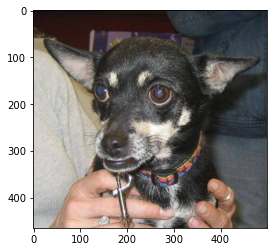

dog.1023.jpg 	assigned [0]
P(cat) = 0.409, P(dog) = 0.591


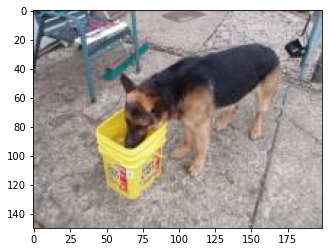

dog.1015.jpg 	assigned [0]
P(cat) = 0.086, P(dog) = 0.914


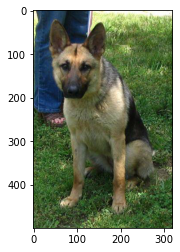

dog.1028.jpg 	assigned [1]
P(cat) = 0.653, P(dog) = 0.347


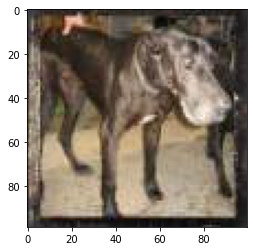

In [83]:
list_images = ['dog.1041.jpg', 'dog.1023.jpg', 'dog.1015.jpg', 'dog.1028.jpg']

for image in list_images:
    path = r'C:\Users\Victor\Downloads\test\{0}'.format(image)
    singleImage = cv2.imread(path)
    histt = extract_histogram(singleImage)
    histt2 = histt.reshape(1, -1)
    prediction = sclf.predict(histt2)
    print(image, "\tassigned", prediction)
    print("P(cat) = {0:.3f}, P(dog) = {1:.3f}".format(sclf.predict_proba(histt2)[0,1], sclf.predict_proba(histt2)[0,0]))
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.show()